In [1]:
import os
import numpy as np
import tqdm
from tqdm.notebook import tqdm_notebook
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import pickle as pk
import sklearn

In [2]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

In [3]:
tqdm_notebook.pandas()

# Train

In [4]:
training_folds = [1,2,3,4,6]
features = ['mfcc', 'spectogram', 'mel_spectogram', 'chroma_stft', 'chroma_cqt', 'chroma_cens', 'spectral_contrast', 'tonnetz', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'poly_features', 'zero_crossing_rate', 'spectral_rolloff']

In [5]:
n_features = 0
feature_matrices = []
for feature in tqdm_notebook(features, desc = "Features loop"):
    feature_matrix = np.load(f'/Users/lizzy/Desktop/Universita/cesab/project/all_data/train_data/{feature}_matrix.npy')
    n_observations = feature_matrix.shape[0]
    if len(feature_matrix.shape) > 2:
        n_features = n_features + feature_matrix.shape[1]
    else:
        n_features = n_features + 1
        n_samples = feature_matrix.shape[1]
    feature_matrices.append(feature_matrix)

Features loop:   0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
X_train = np.ndarray(shape = (n_observations, n_features))

In [7]:
for feature_matrix in tqdm_notebook(feature_matrices, desc = "Features loop"):
    for i in range(X_train.shape[0]):
        feature_count = 0
        if len(feature_matrix.shape) > 2:
            for j in range(feature_matrix.shape[1]):
                X_train[i, feature_count] = np.mean(feature_matrix[i, j])
                feature_count = feature_count + 1
        else:
            X_train[i, feature_count] = np.mean(feature_matrix[i])
            feature_count = feature_count + 1

Features loop:   0%|          | 0/15 [00:00<?, ?it/s]

In [8]:
y_train = np.load('/Users/lizzy/Desktop/Universita/cesab/project/all_data/train_data/training_class.json.npy')

# PCA

Text(0, 0.5, 'Cumulative explained variance')

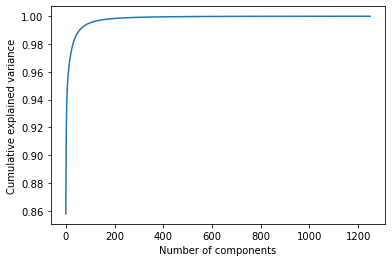

In [9]:
pca = PCA(n_components = n_features)
pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [10]:
print("99% at component: " + str(np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99))))

99% at component: 57


In [11]:
n_comp = np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99))

pca = PCA(n_components=n_comp)
X_pca_train = pca.fit_transform(X_train)
pca_std = np.std(X_pca_train)

print(X_train.shape)
print(X_pca_train.shape)

(4499, 1250)
(4499, 57)


In [12]:
pk.dump(pca, open("pca.pkl","wb"))

# Neural Network

In [13]:
X_pca_train.shape

(4499, 57)

In [14]:
histories = []
for i in range(5):
    if i != 4:
        start = i * 1000
        stop = (i+1)*1000
        val_indices = range(start, stop)
        train_indices = [x for x in range(X_pca_train.shape[0]) if x not in val_indices]
        X_val = X_pca_train[val_indices]
        y_val = y_train[val_indices]
        X_train_reduced = X_pca_train[train_indices]
        y_train_reduced = y_train[train_indices]
    else:
        X_val = X_pca_train[4000:]
        y_val = y_train[4000:]
        X_train_reduced = X_pca_train[:4000]
        y_train_reduced = y_train[:4000]
        
    #model    
    model = Sequential()
    model.add(layers.InputLayer(input_shape = (X_pca_train.shape[1],)))
    for l in range(1):
        model.add(layers.Dense(270, activation='relu'))
        model.add(layers.GaussianNoise(pca_std))
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(180, activation='relu'))
        model.add(layers.GaussianNoise(pca_std))
        model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    #print(model.summary())

    history = model.fit(X_train_reduced,
                        y_train_reduced,
                        epochs=200,
                        batch_size = 10, 
                        validation_data = (X_val, y_val),
                        callbacks = [])
    histories.append((i, history, model))

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-08-31 09:25:06.678935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-31 09:25:06.679542: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


290/350 [=======================>......] - ETA: 0s - loss: 8.3587 - accuracy: 0.1568WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x47d17e820> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
350/350 [==============================] - 1s 1ms/step - loss: 8.1856 - accuracy: 0.1607 - val_loss: 2.4089 - val_accuracy: 0.2160
Epoch

350/350 [==============================] - 0s 606us/step - loss: 0.5963 - accuracy: 0.8289 - val_loss: 7.3395 - val_accuracy: 0.3090
Epoch 107/200
350/350 [==============================] - 0s 625us/step - loss: 0.5737 - accuracy: 0.8162 - val_loss: 7.4329 - val_accuracy: 0.3350
Epoch 108/200
350/350 [==============================] - 0s 637us/step - loss: 0.5923 - accuracy: 0.8309 - val_loss: 7.3175 - val_accuracy: 0.3320
Epoch 109/200
350/350 [==============================] - 0s 619us/step - loss: 0.5873 - accuracy: 0.8288 - val_loss: 7.6342 - val_accuracy: 0.3450
Epoch 110/200
350/350 [==============================] - 0s 658us/step - loss: 0.5336 - accuracy: 0.8359 - val_loss: 7.3565 - val_accuracy: 0.3090
Epoch 111/200
350/350 [==============================] - 0s 646us/step - loss: 0.5332 - accuracy: 0.8394 - val_loss: 6.6353 - val_accuracy: 0.3440
Epoch 112/200
350/350 [==============================] - 0s 589us/step - loss: 0.5394 - accuracy: 0.8397 - val_loss: 6.7460 - val_ac

Epoch 162/200
350/350 [==============================] - 0s 585us/step - loss: 0.4190 - accuracy: 0.8778 - val_loss: 10.2282 - val_accuracy: 0.3360
Epoch 163/200
350/350 [==============================] - 0s 579us/step - loss: 0.4726 - accuracy: 0.8752 - val_loss: 9.8897 - val_accuracy: 0.3550
Epoch 164/200
350/350 [==============================] - 0s 576us/step - loss: 0.4697 - accuracy: 0.8733 - val_loss: 9.0630 - val_accuracy: 0.3760
Epoch 165/200
350/350 [==============================] - 0s 588us/step - loss: 0.4413 - accuracy: 0.8689 - val_loss: 9.6158 - val_accuracy: 0.3880
Epoch 166/200
350/350 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.88 - 0s 576us/step - loss: 0.4381 - accuracy: 0.8816 - val_loss: 10.1004 - val_accuracy: 0.3380
Epoch 167/200
350/350 [==============================] - 0s 580us/step - loss: 0.4417 - accuracy: 0.8822 - val_loss: 10.6225 - val_accuracy: 0.3510
Epoch 168/200
350/350 [==============================] - 0s 576us/step - 

350/350 [==============================] - 0s 591us/step - loss: 0.6701 - accuracy: 0.7790 - val_loss: 3.9133 - val_accuracy: 0.3760
Epoch 61/200
350/350 [==============================] - 0s 633us/step - loss: 0.7261 - accuracy: 0.7683 - val_loss: 4.1489 - val_accuracy: 0.3270
Epoch 62/200
350/350 [==============================] - 0s 581us/step - loss: 0.7076 - accuracy: 0.7696 - val_loss: 3.7363 - val_accuracy: 0.3820
Epoch 63/200
350/350 [==============================] - 0s 582us/step - loss: 0.6896 - accuracy: 0.7844 - val_loss: 4.1207 - val_accuracy: 0.3580
Epoch 64/200
350/350 [==============================] - 0s 625us/step - loss: 0.7067 - accuracy: 0.7664 - val_loss: 4.3260 - val_accuracy: 0.3540
Epoch 65/200
350/350 [==============================] - 0s 620us/step - loss: 0.6836 - accuracy: 0.7932 - val_loss: 4.0919 - val_accuracy: 0.3750
Epoch 66/200
350/350 [==============================] - 0s 585us/step - loss: 0.7141 - accuracy: 0.7736 - val_loss: 4.2378 - val_accuracy

350/350 [==============================] - 0s 599us/step - loss: 0.4924 - accuracy: 0.8575 - val_loss: 6.4981 - val_accuracy: 0.3680
Epoch 117/200
350/350 [==============================] - 0s 637us/step - loss: 0.5229 - accuracy: 0.8496 - val_loss: 7.3728 - val_accuracy: 0.3490
Epoch 118/200
350/350 [==============================] - 0s 590us/step - loss: 0.5275 - accuracy: 0.8514 - val_loss: 7.0176 - val_accuracy: 0.3480
Epoch 119/200
350/350 [==============================] - 0s 687us/step - loss: 0.5443 - accuracy: 0.8438 - val_loss: 6.7207 - val_accuracy: 0.3590
Epoch 120/200
350/350 [==============================] - 0s 616us/step - loss: 0.4828 - accuracy: 0.8599 - val_loss: 7.3151 - val_accuracy: 0.3690
Epoch 121/200
350/350 [==============================] - 0s 632us/step - loss: 0.4971 - accuracy: 0.8621 - val_loss: 7.2762 - val_accuracy: 0.3620
Epoch 122/200
350/350 [==============================] - 0s 580us/step - loss: 0.4912 - accuracy: 0.8595 - val_loss: 8.1930 - val_ac

Epoch 172/200
350/350 [==============================] - 0s 642us/step - loss: 0.4857 - accuracy: 0.8893 - val_loss: 10.8219 - val_accuracy: 0.3660
Epoch 173/200
350/350 [==============================] - 0s 598us/step - loss: 0.3871 - accuracy: 0.8957 - val_loss: 12.1646 - val_accuracy: 0.3510
Epoch 174/200
350/350 [==============================] - 0s 580us/step - loss: 0.4490 - accuracy: 0.8918 - val_loss: 11.9650 - val_accuracy: 0.3540
Epoch 175/200
350/350 [==============================] - 0s 585us/step - loss: 0.3637 - accuracy: 0.9029 - val_loss: 11.5833 - val_accuracy: 0.3520
Epoch 176/200
350/350 [==============================] - 0s 581us/step - loss: 0.3915 - accuracy: 0.9023 - val_loss: 12.8414 - val_accuracy: 0.3510
Epoch 177/200
350/350 [==============================] - 0s 586us/step - loss: 0.4718 - accuracy: 0.8897 - val_loss: 12.5318 - val_accuracy: 0.3670
Epoch 178/200
350/350 [==============================] - 0s 587us/step - loss: 0.4267 - accuracy: 0.8898 - val_l

350/350 [==============================] - 0s 677us/step - loss: 0.7207 - accuracy: 0.7568 - val_loss: 5.8259 - val_accuracy: 0.4140
Epoch 71/200
350/350 [==============================] - 0s 653us/step - loss: 0.6766 - accuracy: 0.7733 - val_loss: 5.9272 - val_accuracy: 0.3930
Epoch 72/200
350/350 [==============================] - 0s 615us/step - loss: 0.7313 - accuracy: 0.7691 - val_loss: 5.6298 - val_accuracy: 0.3910
Epoch 73/200
350/350 [==============================] - 0s 630us/step - loss: 0.6961 - accuracy: 0.7803 - val_loss: 5.3425 - val_accuracy: 0.3790
Epoch 74/200
350/350 [==============================] - 0s 641us/step - loss: 0.6921 - accuracy: 0.7755 - val_loss: 6.0234 - val_accuracy: 0.4120
Epoch 75/200
350/350 [==============================] - 0s 722us/step - loss: 0.7482 - accuracy: 0.7588 - val_loss: 5.9636 - val_accuracy: 0.3650
Epoch 76/200
350/350 [==============================] - 0s 652us/step - loss: 0.7234 - accuracy: 0.7593 - val_loss: 5.4685 - val_accuracy

350/350 [==============================] - 0s 643us/step - loss: 0.6055 - accuracy: 0.8225 - val_loss: 9.5704 - val_accuracy: 0.3700
Epoch 127/200
350/350 [==============================] - 0s 637us/step - loss: 0.5350 - accuracy: 0.8462 - val_loss: 9.3913 - val_accuracy: 0.3920
Epoch 128/200
350/350 [==============================] - 0s 637us/step - loss: 0.5116 - accuracy: 0.8450 - val_loss: 9.9681 - val_accuracy: 0.4040
Epoch 129/200
350/350 [==============================] - 0s 607us/step - loss: 0.4681 - accuracy: 0.8569 - val_loss: 8.9276 - val_accuracy: 0.4150
Epoch 130/200
350/350 [==============================] - 0s 631us/step - loss: 0.5039 - accuracy: 0.8550 - val_loss: 9.1275 - val_accuracy: 0.3950
Epoch 131/200
350/350 [==============================] - 0s 618us/step - loss: 0.5427 - accuracy: 0.8480 - val_loss: 7.8882 - val_accuracy: 0.3800
Epoch 132/200
350/350 [==============================] - 0s 606us/step - loss: 0.5553 - accuracy: 0.8439 - val_loss: 8.2252 - val_ac

Epoch 24/200
350/350 [==============================] - 0s 590us/step - loss: 1.0345 - accuracy: 0.6482 - val_loss: 2.9230 - val_accuracy: 0.3220
Epoch 25/200
350/350 [==============================] - 0s 587us/step - loss: 1.0514 - accuracy: 0.6381 - val_loss: 2.9290 - val_accuracy: 0.3230
Epoch 26/200
350/350 [==============================] - 0s 589us/step - loss: 1.0296 - accuracy: 0.6648 - val_loss: 2.8848 - val_accuracy: 0.3160
Epoch 27/200
350/350 [==============================] - 0s 592us/step - loss: 1.0059 - accuracy: 0.6693 - val_loss: 3.0943 - val_accuracy: 0.3200
Epoch 28/200
350/350 [==============================] - 0s 590us/step - loss: 0.9703 - accuracy: 0.6788 - val_loss: 3.1925 - val_accuracy: 0.3070
Epoch 29/200
350/350 [==============================] - 0s 594us/step - loss: 0.9740 - accuracy: 0.6776 - val_loss: 3.2713 - val_accuracy: 0.3060
Epoch 30/200
350/350 [==============================] - 0s 590us/step - loss: 0.9498 - accuracy: 0.6864 - val_loss: 3.0705 -

Epoch 136/200
350/350 [==============================] - 0s 589us/step - loss: 0.4289 - accuracy: 0.8767 - val_loss: 11.0793 - val_accuracy: 0.3640
Epoch 137/200
350/350 [==============================] - 0s 585us/step - loss: 0.4320 - accuracy: 0.8831 - val_loss: 11.0063 - val_accuracy: 0.3450
Epoch 138/200
350/350 [==============================] - 0s 587us/step - loss: 0.5086 - accuracy: 0.8585 - val_loss: 12.5148 - val_accuracy: 0.3150
Epoch 139/200
350/350 [==============================] - 0s 592us/step - loss: 0.5131 - accuracy: 0.8717 - val_loss: 10.3653 - val_accuracy: 0.3670
Epoch 140/200
350/350 [==============================] - 0s 587us/step - loss: 0.4078 - accuracy: 0.8809 - val_loss: 10.8357 - val_accuracy: 0.3800
Epoch 141/200
350/350 [==============================] - 0s 591us/step - loss: 0.4364 - accuracy: 0.8785 - val_loss: 11.7428 - val_accuracy: 0.3610
Epoch 142/200
350/350 [==============================] - 0s 591us/step - loss: 0.4454 - accuracy: 0.8762 - val_l

Epoch 34/200
400/400 [==============================] - 0s 521us/step - loss: 0.9423 - accuracy: 0.6852 - val_loss: 3.1999 - val_accuracy: 0.3327
Epoch 35/200
400/400 [==============================] - 0s 516us/step - loss: 0.8886 - accuracy: 0.7075 - val_loss: 3.2856 - val_accuracy: 0.3407
Epoch 36/200
400/400 [==============================] - 0s 517us/step - loss: 0.9396 - accuracy: 0.6756 - val_loss: 3.3957 - val_accuracy: 0.3427
Epoch 37/200
400/400 [==============================] - 0s 517us/step - loss: 0.8853 - accuracy: 0.7147 - val_loss: 2.9174 - val_accuracy: 0.3627
Epoch 38/200
400/400 [==============================] - 0s 519us/step - loss: 0.8404 - accuracy: 0.7178 - val_loss: 3.2252 - val_accuracy: 0.3467
Epoch 39/200
400/400 [==============================] - 0s 520us/step - loss: 0.8949 - accuracy: 0.7052 - val_loss: 3.3950 - val_accuracy: 0.3086
Epoch 40/200
400/400 [==============================] - 0s 518us/step - loss: 0.8627 - accuracy: 0.7121 - val_loss: 3.5619 -

Epoch 146/200
400/400 [==============================] - 0s 536us/step - loss: 0.4890 - accuracy: 0.8668 - val_loss: 7.0969 - val_accuracy: 0.3908
Epoch 147/200
400/400 [==============================] - 0s 526us/step - loss: 0.4764 - accuracy: 0.8799 - val_loss: 7.6125 - val_accuracy: 0.3788
Epoch 148/200
400/400 [==============================] - 0s 521us/step - loss: 0.4789 - accuracy: 0.8701 - val_loss: 8.7966 - val_accuracy: 0.3928
Epoch 149/200
400/400 [==============================] - 0s 522us/step - loss: 0.4860 - accuracy: 0.8693 - val_loss: 8.1082 - val_accuracy: 0.3908
Epoch 150/200
400/400 [==============================] - 0s 523us/step - loss: 0.4743 - accuracy: 0.8678 - val_loss: 7.5018 - val_accuracy: 0.4248
Epoch 151/200
400/400 [==============================] - 0s 523us/step - loss: 0.4872 - accuracy: 0.8712 - val_loss: 8.6489 - val_accuracy: 0.4349
Epoch 152/200
400/400 [==============================] - 0s 522us/step - loss: 0.4880 - accuracy: 0.8672 - val_loss: 7

In [15]:
summary_history = dict({'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]})
for h in histories:
    summary_history['loss'].append(h[1].history['loss'][-1])
    summary_history['accuracy'].append(h[1].history['accuracy'][-1])
    summary_history['val_loss'].append(h[1].history['val_loss'][-1]) 
    summary_history['val_accuracy'].append(h[1].history['val_accuracy'][-1])
summary_history = pd.DataFrame(summary_history)
summary_history

,loss,accuracy,val_loss,val_accuracy
0,0.468621,0.892255,12.248960,0.345000
1,0.438599,0.891683,15.059649,0.350000
2,0.475438,0.880537,13.666737,0.390000
3,0.371665,0.911117,16.812775,0.349000
4,0.484154,0.890500,9.491314,0.426854


In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

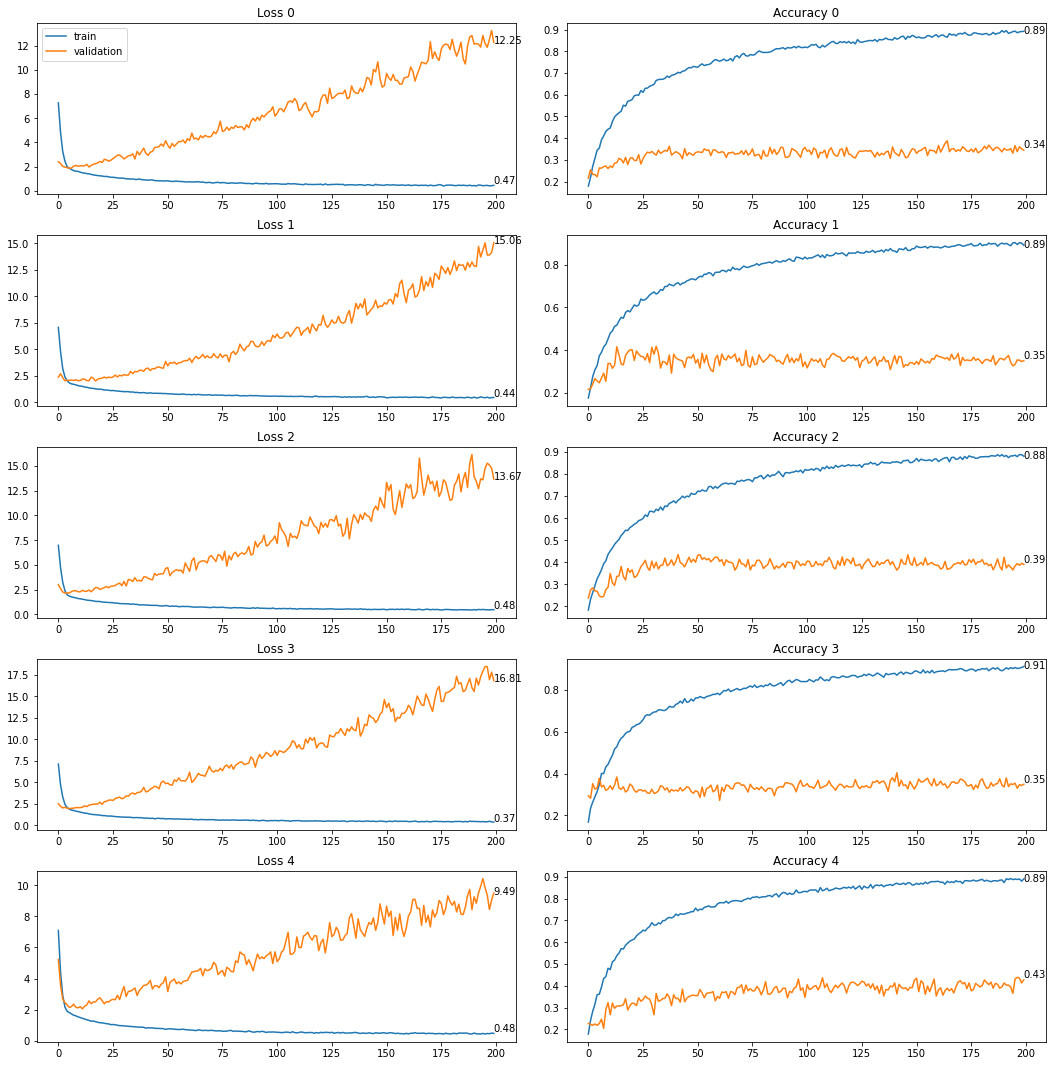

In [17]:
fig, axs = plt.subplots(5, 2,figsize=(15,15))
fig.tight_layout(pad=2.0)
for h, i in zip(histories, range(len(histories))):
    axs[i, 0].plot(h[1].history['loss'])
    axs[i, 0].plot(h[1].history['val_loss'])
    axs[i, 0].set_title(f'Loss {i}')
    axs[i, 0].annotate(str(round(h[1].history['loss'][-1], 2)),
                       xy = (199, h[1].history['loss'][-1]),
                       xytext = (199, h[1].history['loss'][-1] + 0.1))
    axs[i, 0].annotate(str(round(h[1].history['val_loss'][-1], 2)),
                       xy = (199, h[1].history['val_loss'][-1]),
                       xytext = (199, h[1].history['val_loss'][-1] - 0.1))
    axs[0, 0].legend(['train', 'validation'], loc='upper left')
    axs[i, 1].plot(h[1].history['accuracy'])
    axs[i, 1].plot(h[1].history['val_accuracy'])
    axs[i, 1].set_title(f'Accuracy {i}')
    axs[i, 1].annotate(str(round(h[1].history['accuracy'][-1], 2)),
                       xy = (199, h[1].history['accuracy'][-1]),
                       xytext = (199, h[1].history['accuracy'][-1] - 0.01))
    axs[i, 1].annotate(str(round(h[1].history['val_accuracy'][-1], 2)),
                       xy = (199, h[1].history['val_accuracy'][-1]),
                       xytext = (199, h[1].history['val_accuracy'][-1] + 0.01))

In [18]:
fig.savefig('mean_data_pca_val.pdf')
summary_history.to_csv('summary_history_mean_data_pca_val.csv')

In [19]:
#best model: highest validation accuracy
best_model_index = summary_history['val_accuracy'].idxmax()
best_model = histories[best_model_index][2]
best_model.save('mean_data_pca_val')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


/Users/lizzy/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-08-31 09:28:44.460019: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/Users/lizzy/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: mean_data_pca_val/assets


# Train without validation

In [22]:
model = Sequential()
model.add(layers.InputLayer(input_shape = (X_pca_train.shape[1],)))
for l in range(1):
    model.add(layers.Dense(270, activation='relu'))
    model.add(layers.GaussianNoise(pca_std))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(180, activation='relu'))
    model.add(layers.GaussianNoise(pca_std))
    model.add(layers.Dropout(0.1))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#print(model.summary())

history = model.fit(X_pca_train,
                    y_train,
                    epochs=200,
                    batch_size = 10, 
                    callbacks = [])

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
450/450 [==============================] - 0s 514us/step - loss: 7.9456 - accuracy: 0.1500
Epoch 2/200
450/450 [==============================] - 0s 499us/step - loss: 4.7903 - accuracy: 0.2036
Epoch 3/200
450/450 [==============================] - 0s 497us/step - loss: 2.9499 - accuracy: 0.2618
Epoch 4/200
450/450 [==============================] - 0s

450/450 [==============================] - 0s 510us/step - loss: 0.6957 - accuracy: 0.7814
Epoch 72/200
450/450 [==============================] - 0s 499us/step - loss: 0.7621 - accuracy: 0.7682
Epoch 73/200
450/450 [==============================] - 0s 502us/step - loss: 0.6962 - accuracy: 0.7811
Epoch 74/200
450/450 [==============================] - 0s 500us/step - loss: 0.6927 - accuracy: 0.7830
Epoch 75/200
450/450 [==============================] - 0s 500us/step - loss: 0.6647 - accuracy: 0.7910
Epoch 76/200
450/450 [==============================] - 0s 501us/step - loss: 0.6691 - accuracy: 0.7950
Epoch 77/200
450/450 [==============================] - 0s 502us/step - loss: 0.6874 - accuracy: 0.7889
Epoch 78/200
450/450 [==============================] - 0s 501us/step - loss: 0.6820 - accuracy: 0.7800
Epoch 79/200
450/450 [==============================] - 0s 502us/step - loss: 0.6553 - accuracy: 0.7927
Epoch 80/200
450/450 [==============================] - 0s 496us/step - loss:

In [23]:
summary_history = dict({'loss':[], 'accuracy':[]})
summary_history['loss'].append(history.history['loss'][-1])
summary_history['accuracy'].append(history.history['accuracy'][-1])
summary_history = pd.DataFrame(summary_history)
summary_history

,loss,accuracy
0,0.4839,0.889976


Text(199, 0.8799755477905273, '0.89')

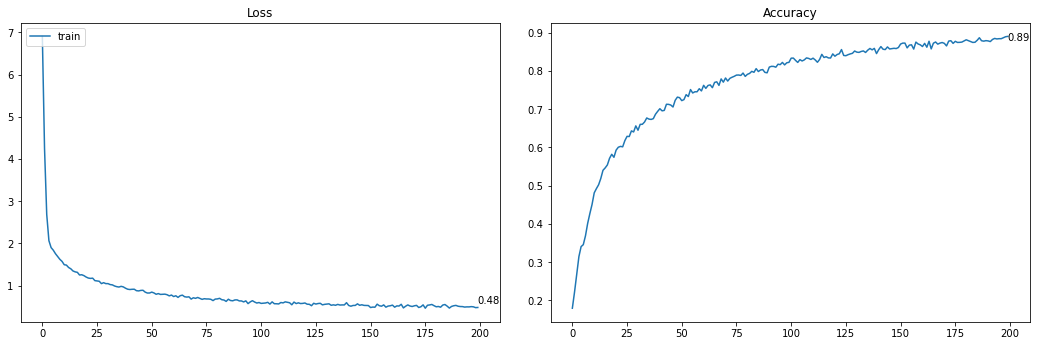

In [24]:
fig, axs = plt.subplots(1, 2,figsize=(15,5))
fig.tight_layout(pad=2.0)
axs[0].plot(history.history['loss'])
axs[0].set_title(f'Loss')
axs[0].annotate(str(round(history.history['loss'][-1], 2)),
                   xy = (199, history.history['loss'][-1]),
                   xytext = (199, history.history['loss'][-1] + 0.1))
axs[0].legend(['train'], loc='upper left')
axs[1].plot(history.history['accuracy'])
axs[1].set_title(f'Accuracy')
axs[1].annotate(str(round(history.history['accuracy'][-1], 2)),
                   xy = (199, history.history['accuracy'][-1]),
                   xytext = (199, history.history['accuracy'][-1] - 0.01))

In [25]:
fig.savefig('mean_data_pca.pdf')
summary_history.to_csv('summary_history_mean_data_pca.csv')

In [26]:
model.save('mean_data_pca')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


/Users/lizzy/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/lizzy/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: mean_data_pca/assets


# Test

In [4]:
test_folds = [5,7,8,9,10]
features = ['mfcc', 'spectogram', 'mel_spectogram', 'chroma_stft', 'chroma_cqt', 'chroma_cens', 'spectral_contrast', 'tonnetz', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'poly_features', 'zero_crossing_rate', 'spectral_rolloff']

In [5]:
n_features = 0
feature_matrices = []
for feature in tqdm_notebook(features, desc = "Features loop"):
    feature_matrix = np.load(f'/Users/lizzy/Desktop/Universita/cesab/project/all_data/test_data/{feature}_matrix.npy')
    n_observations = feature_matrix.shape[0]
    if len(feature_matrix.shape) > 2:
        n_features = n_features + feature_matrix.shape[1]
    else:
        n_features = n_features + 1
        n_samples = feature_matrix.shape[1]
    feature_matrices.append(feature_matrix)

Features loop:   0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
X_test = np.ndarray(shape = (n_observations, n_features))

In [7]:
for feature_matrix in tqdm_notebook(feature_matrices, desc = "Features loop"):
    for i in range(X_test.shape[0]):
        feature_count = 0
        if len(feature_matrix.shape) > 2:
            for j in range(feature_matrix.shape[1]):
                X_test[i, feature_count] = np.mean(feature_matrix[i, j])
                feature_count = feature_count + 1
        else:
            X_test[i, feature_count] = np.mean(feature_matrix[i])
            feature_count = feature_count + 1

Features loop:   0%|          | 0/15 [00:00<?, ?it/s]

In [8]:
y_test = np.load('/Users/lizzy/Desktop/Universita/cesab/project/all_data/test_data/test_class.json.npy')

In [9]:
pca = pk.load(open("pca.pkl",'rb'))

In [10]:
X_pca_test = pca.transform(X_test)

In [3]:
model =  tensorflow.keras.models.load_model("mean_data_pca")

In [4]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 270)               15660     
_________________________________________________________________
gaussian_noise_14 (GaussianN (None, 270)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 270)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 180)               48780     
_________________________________________________________________
gaussian_noise_15 (GaussianN (None, 180)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 180)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)               

In [12]:
evaluation = model.evaluate(X_pca_test, y_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
133/133 [==============================] - 0s 309us/step - loss: 16.0569 - accuracy: 0.4444


2021-08-31 09:33:04.257819: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-31 09:33:04.257973: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


In [13]:
print(f'Loss: {evaluation[0]}, accuracy:{evaluation[1]}')

Loss: 16.056880950927734, accuracy:0.4443657100200653


In [15]:
y_pred = model.predict(X_pca_test)

In [16]:
matrix = sklearn.metrics.confusion_matrix(y_test, y_pred.argmax(axis=1))

In [17]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

In [18]:
scores = dict({'Class':[], 'Precision':[], 'Recall':[]})
for cl in range(10):
    precision = matrix[cl,cl] / sum(matrix[:,cl]) #tp/(tp+fp)
    recall = matrix[cl,cl] / sum(matrix[cl,:]) #tp/(tp+fn)
    scores['Class'].append(labels[cl])
    scores['Precision'].append(precision)
    scores['Recall'].append(recall)
scores = pd.DataFrame(scores)
scores

,Class,Precision,Recall
0,air_conditioner,0.535433,0.272000
1,car_horn,0.645714,0.511312
2,children_playing,0.460420,0.570000
3,dog_bark,0.438280,0.632000
4,drilling,0.320057,0.450000
5,engine_idling,0.474419,0.211180
6,gun_shot,0.752809,0.728261
7,jackhammer,0.383838,0.252212
8,siren,0.651007,0.493639
9,street_music,0.338939,0.524000


In [19]:
scores.to_csv('scores_mean_data_pca.csv')